In [30]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

import numpy as np
import h5py
import os
from numba import njit, prange

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 
from ctapipe.image.extractor import LocalPeakWindowSum
from lstchain.calib.camera.r0 import LSTR0Corrections

from lstchain.calib.camera.time_correction_calculate import TimeCorrectionCalculate 
from lstchain.calib.camera.pulse_time_correction import PulseTimeCorrection

plt.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:

def plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal):
    fc = np.arange(0, n_cap, n_combine)
    y = np.zeros(n)

    for i in range(0, len(y)):
        temp_cos = an[0] / 2
        temp_sin = 0
        for j in range(1, len(an)):
            temp_cos += an[j] * np.cos(2 * j * np.pi * (fc[i] / n_cap))
            temp_sin += bn[j] * np.sin(2 * j * np.pi * (fc[i] / n_cap))
        y[i] = (temp_cos + temp_sin)

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(np.arange(0, n_cap, n_combine), fMeanVal, 'bo')
    ax.plot(fc, y, 'r--')
    ax.set_ylabel("Mean arrival time")
    ax.set_xlabel("Position in the DRS ring")
    return fig

# Create coeff and save to h5py file

In [42]:
reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0000.fits.fz",
    max_events=50000)

timeCorr = TimeCorrectionCalculate()

lst_r0 = LSTR0Corrections(tel_id=1)

for i, ev in enumerate(reader):
    if ev.r0.event_id%2000 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)
    if ev.r0.tel[1].trigger_type == 1 and np.mean(ev.r1.tel[1].waveform[0, 15:25, 2:38]) > 150:
        timeCorr.call_calib_pulse_time_jit(ev)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000


In [43]:
timeCorr.finalize()

In [45]:
timeCorr.save_to_h5_file("test_calib_run1625.h5")

In [11]:
! ls *.h5

test_calib_run1625.h5


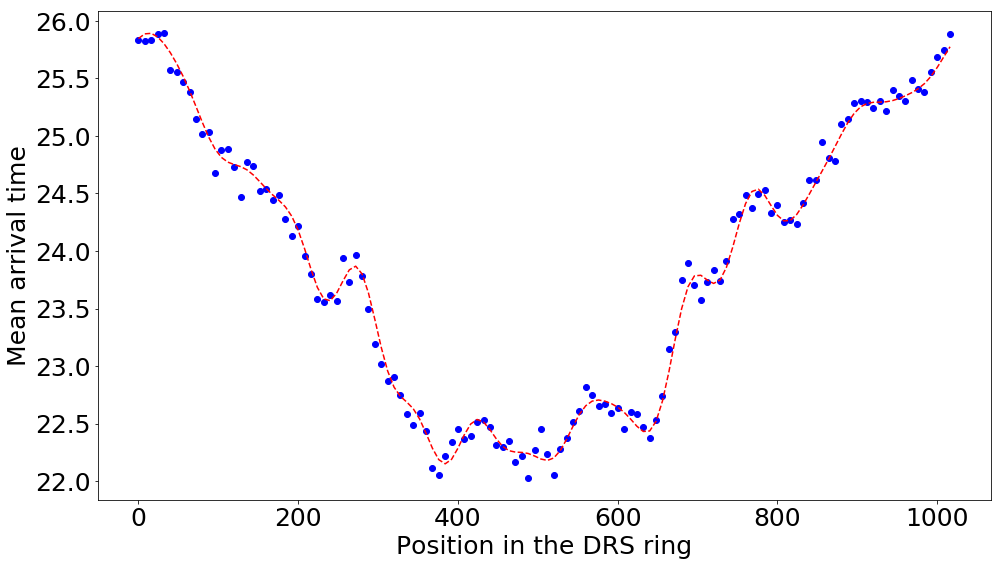

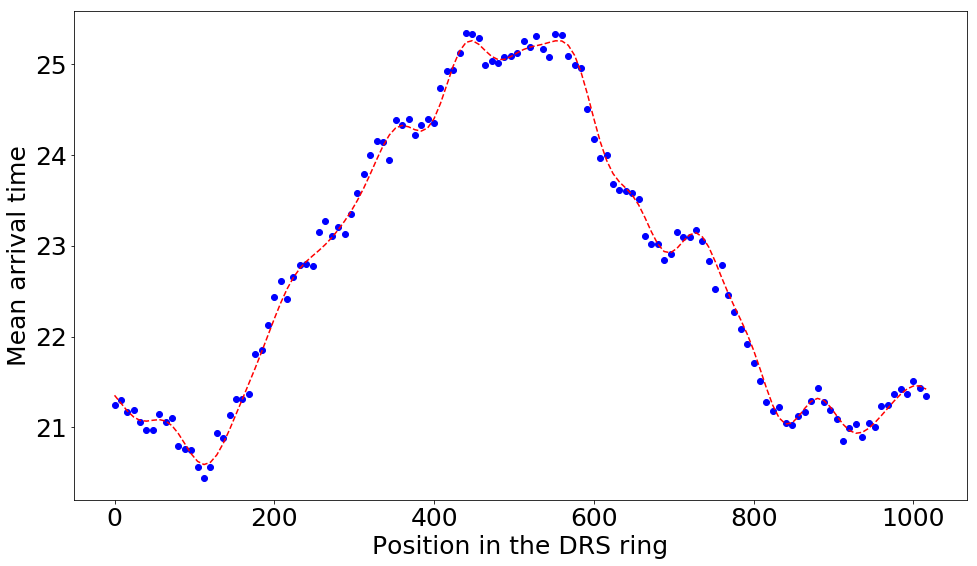

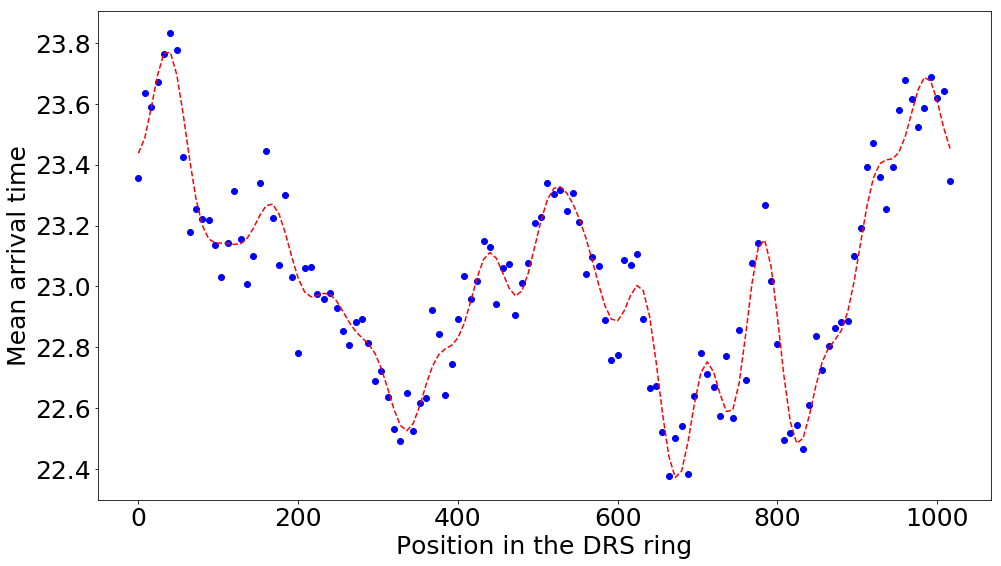

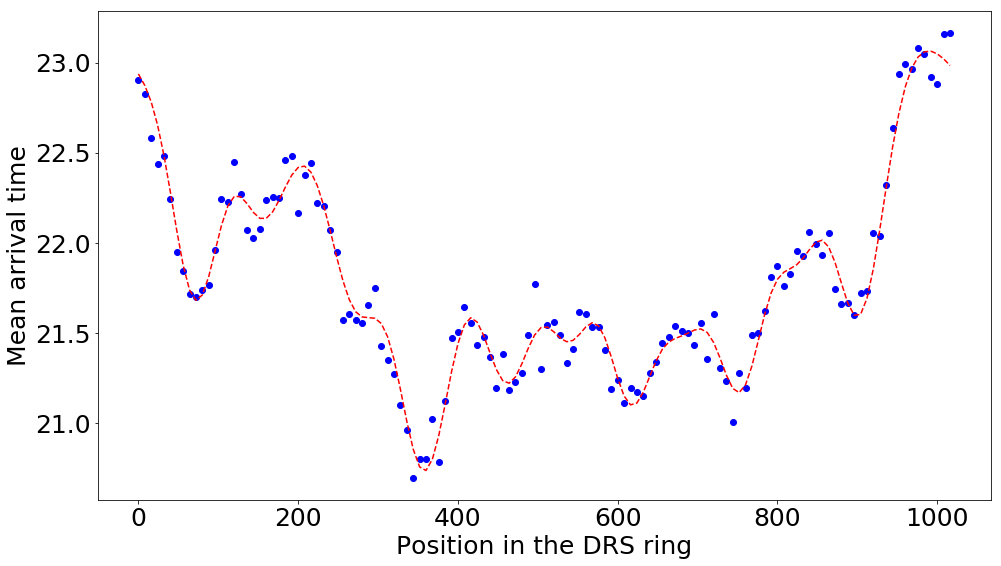

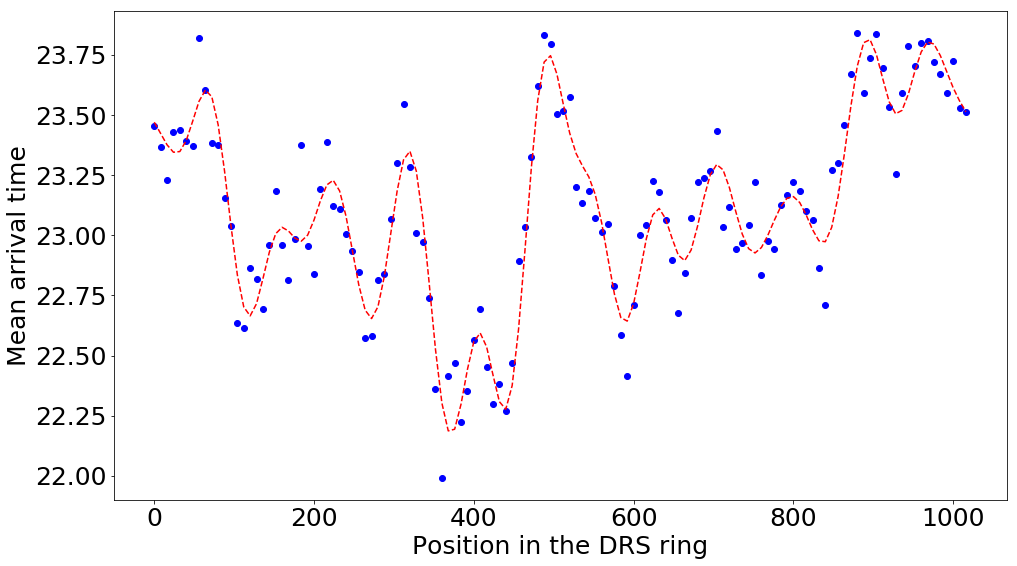

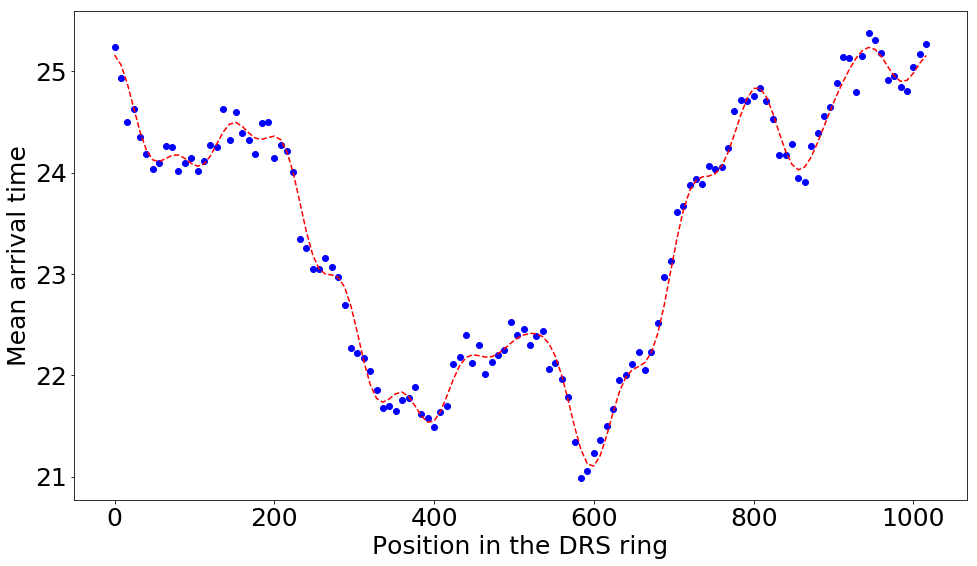

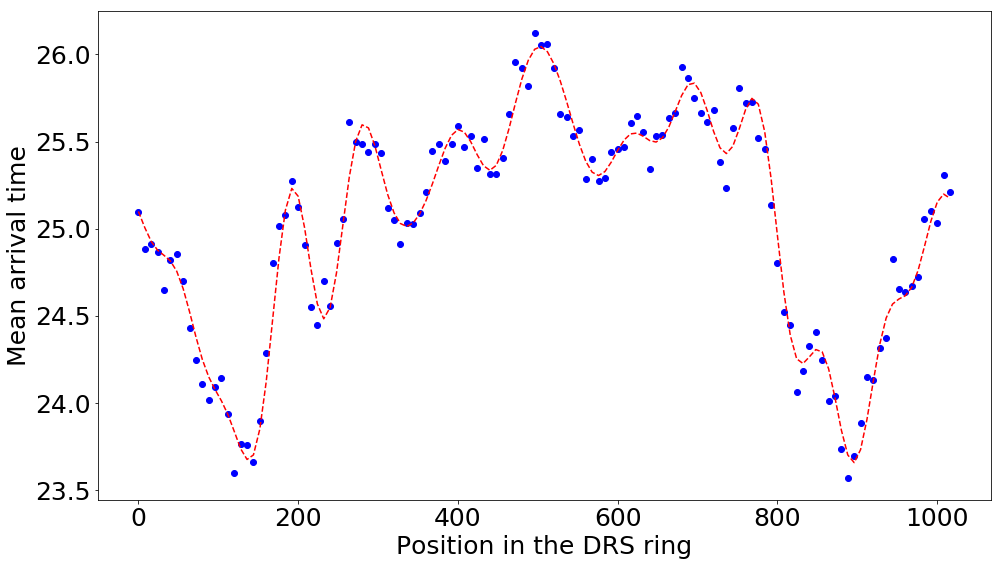

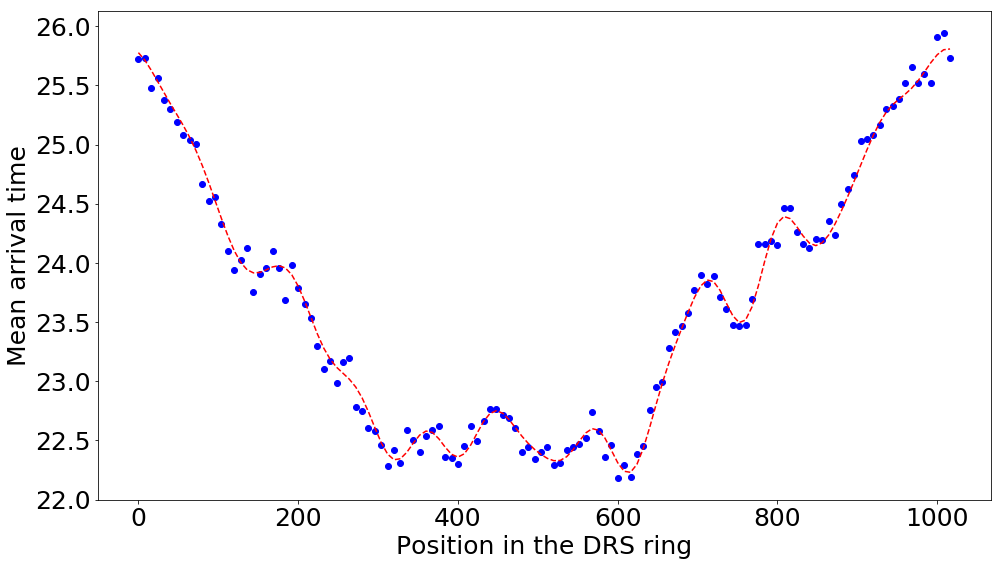

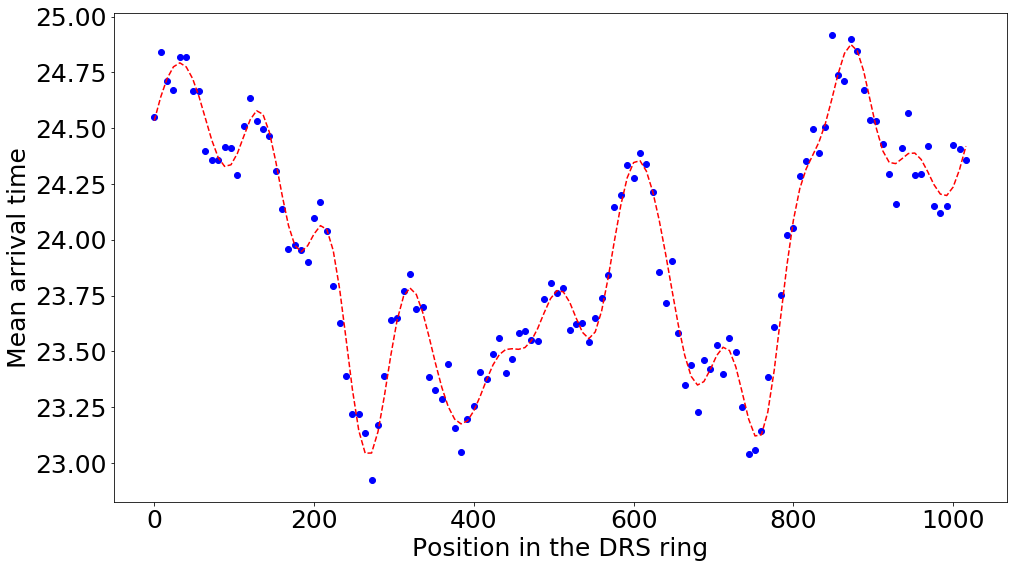

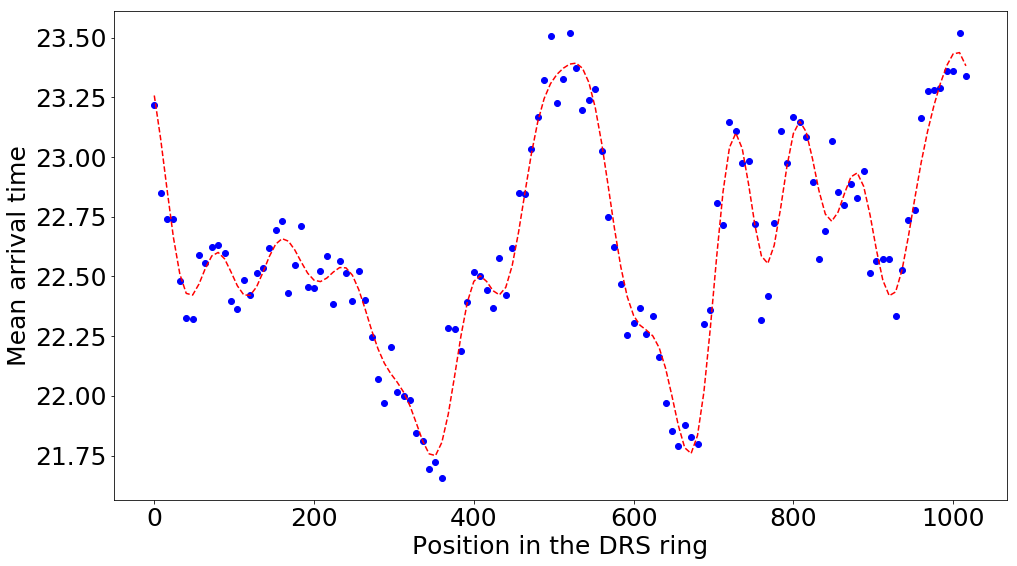

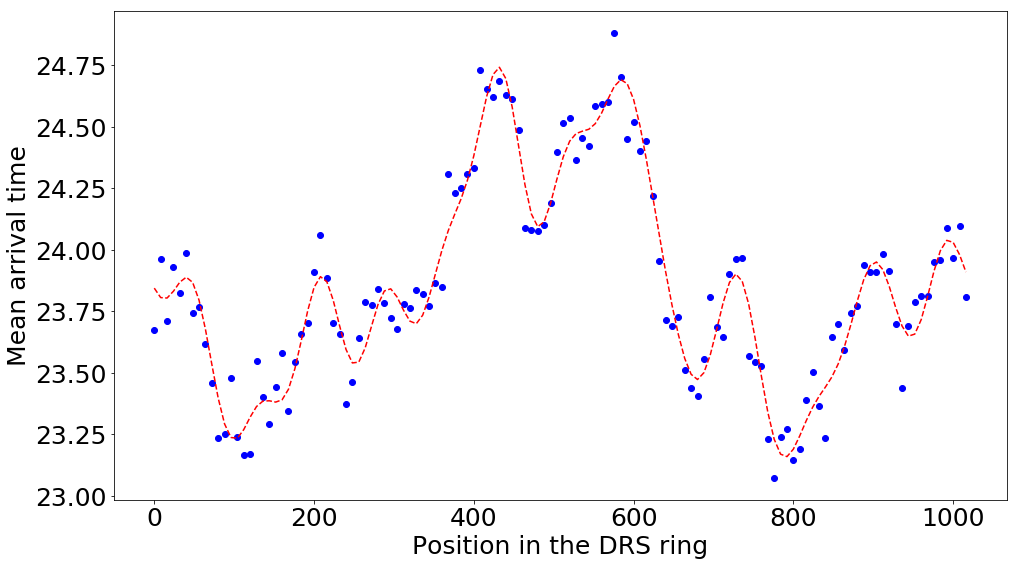

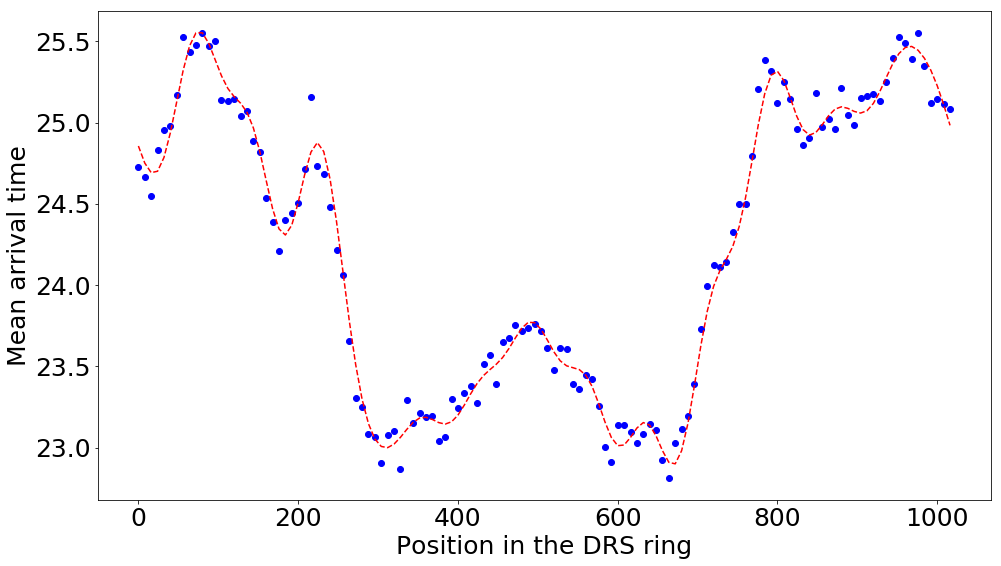

In [44]:
for gain in [0, 1]:
    for pix_id in [10, 150, 250, 280, 1000, 1200]:
        timeCorr.fit(pix_id, gain=gain)
        an = timeCorr.fan
        bn = timeCorr.fbn
        fMeanVal = timeCorr.fMeanVal[gain, pix_id]
        fig = plot_corr_curve(timeCorr.n, timeCorr.n_cap, timeCorr.n_combine, an, bn, fMeanVal)
        plt.show()

# Apply time correction to calib data

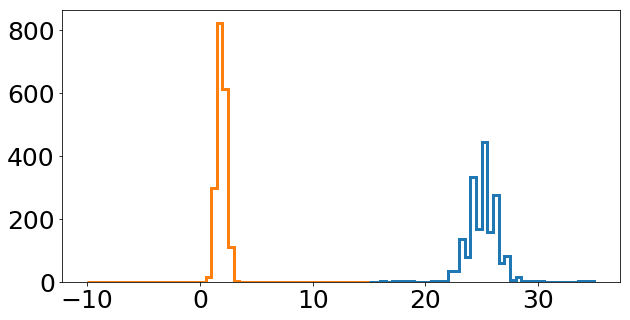

1.418118918177548
0.3922644441627031


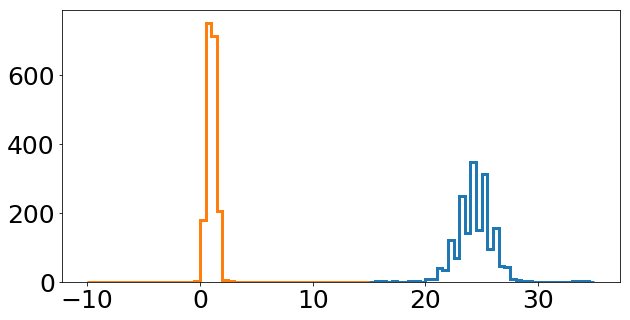

1.6198709343042759
0.39211300937378013


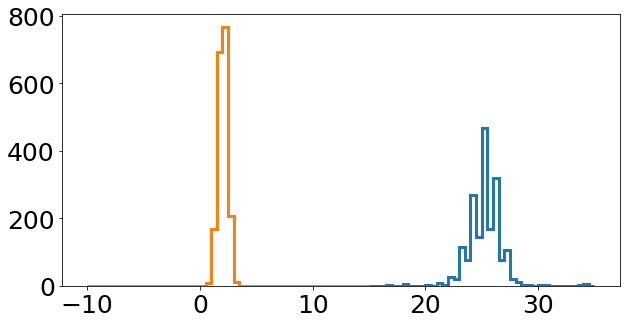

1.4013149798922493
0.39901542256992334


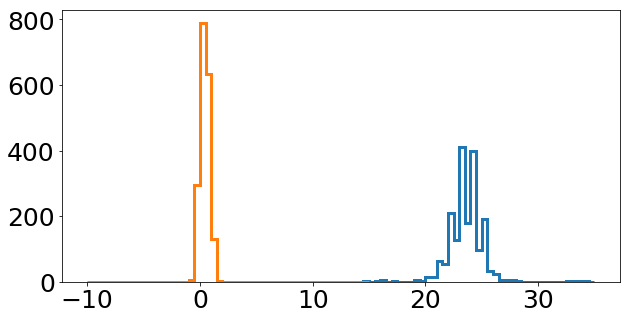

1.4290956538070176
0.39490758364239575


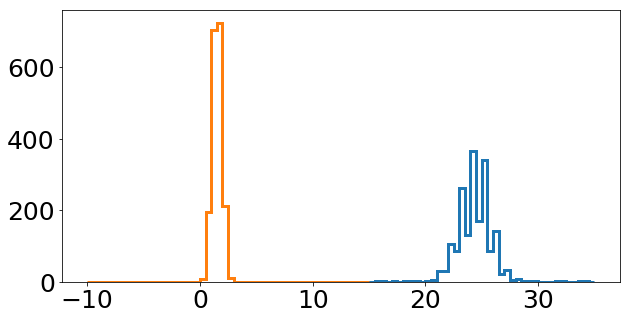

1.544893626966348
0.40856041760593265


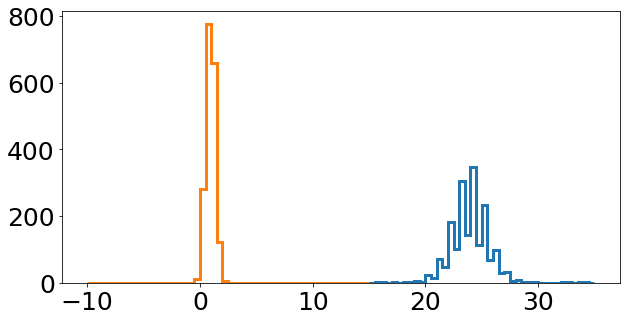

1.7088650051940737
0.3965737850579289


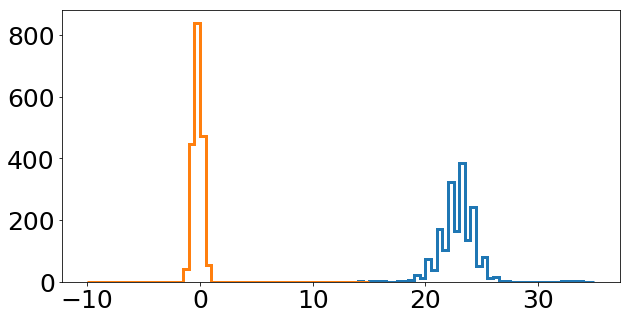

1.5569078542413402
0.3872366244400232


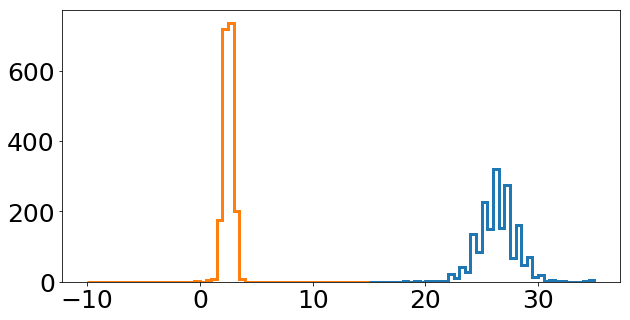

1.7377550209720067
0.41494212079080645


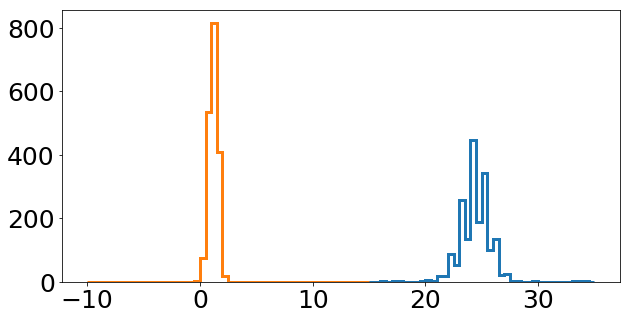

1.4180888691560474
0.39050739950465146


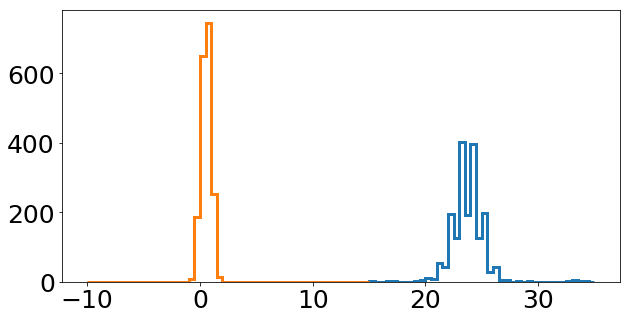

1.4143723553307488
0.4187689763073418


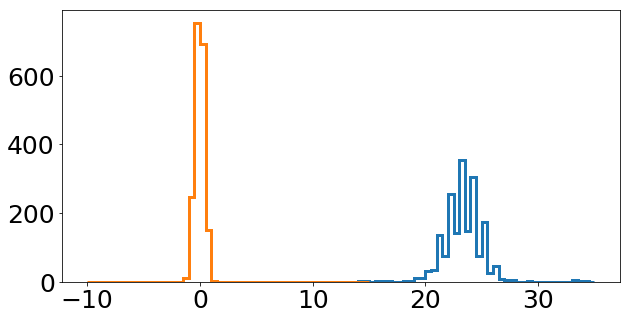

1.6407556120932714
0.39472316540808555


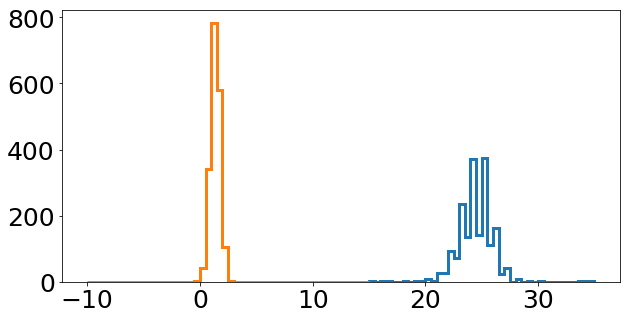

1.5427668692408105
0.42390478461002823


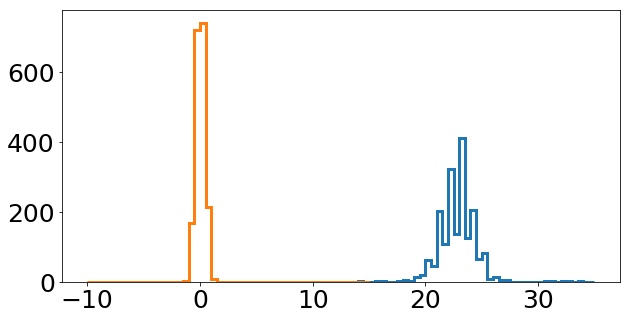

1.5742255856122034
0.3888428231520802


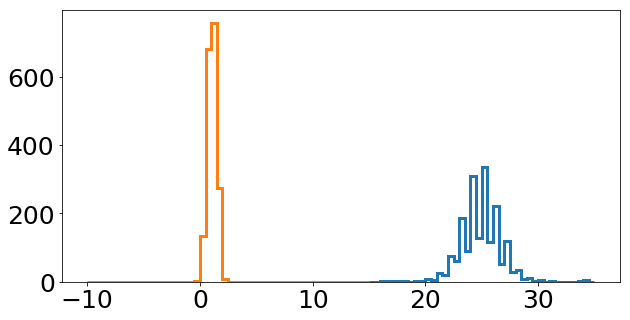

1.7680398484917168
0.39256386764239365


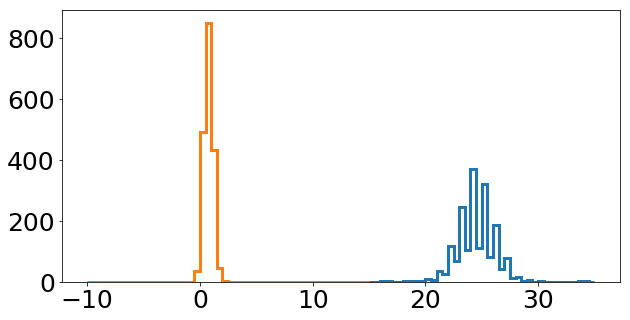

1.7062118591294388
0.390963369036652


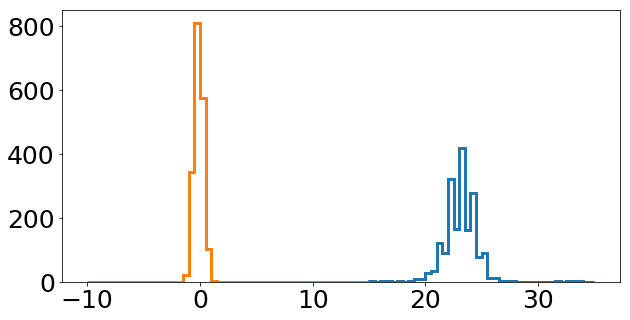

1.446444075881158
0.40319738231501817


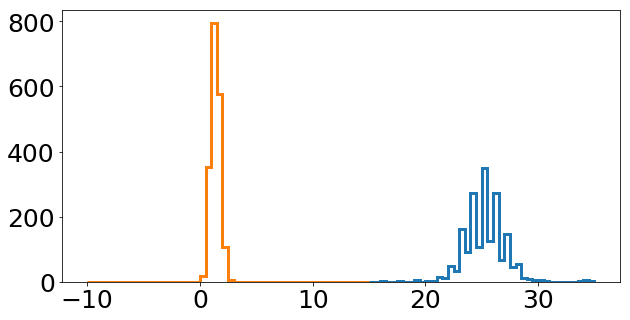

1.7356595907889245
0.4028293087215664


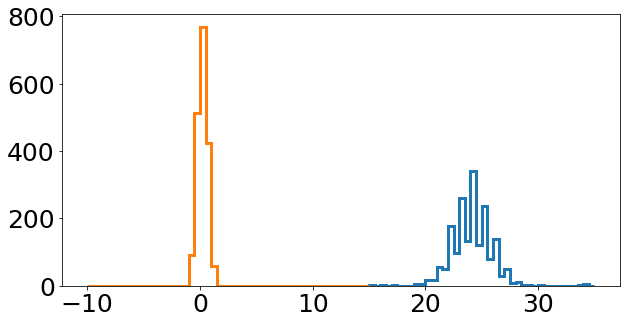

1.7642143426016832
0.42885969134477153


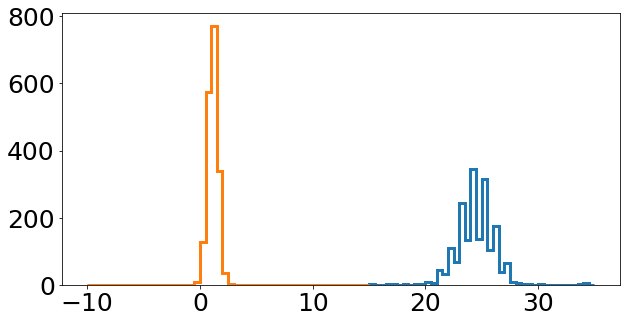

1.6407920301627101
0.4333656114103667


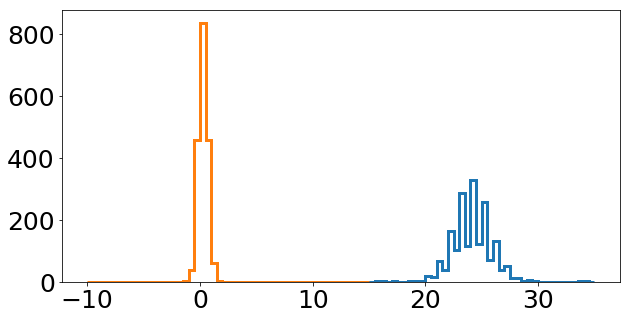

1.771723907409934
0.3980693594536212


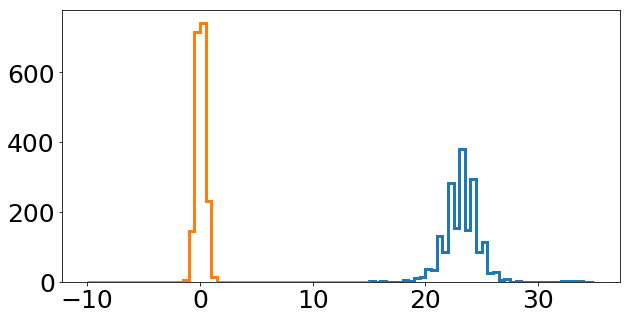

1.5635059555588415
0.3994647269740428


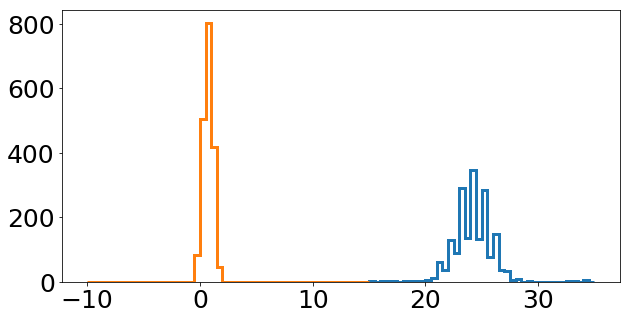

1.6577526317521358
0.4158973201910525


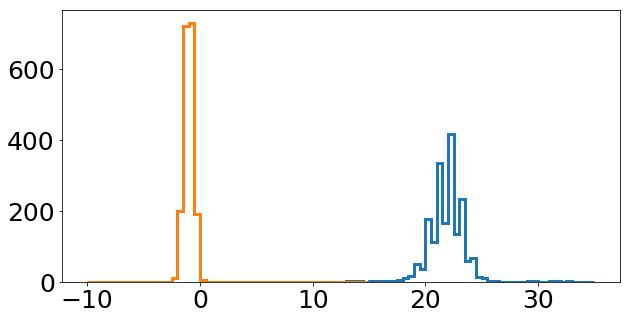

1.4985182207109886
0.39638727979338995


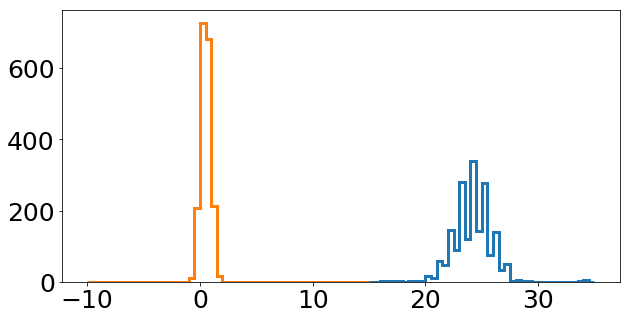

1.6978479196991139
0.4181273220154336


In [46]:
reader = LSTEventSource(
    input_url="/media/pawel1/ADATA HD330/20191124/LST-1.1.Run01625.0001.fits.fz",
    max_events=50)

pulse_corr = PulseTimeCorrection(calib_file_path="test_calib_run1625.h5", n_harm=16)

lst_r0 = LSTR0Corrections(tel_id=1)
extractor = LocalPeakWindowSum()

for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)
    if ev.r0.tel[1].trigger_type == 1 and np.mean(ev.r1.tel[1].waveform[0, 15:25, 2:38]) > 150:
        charge, pulse = extractor(ev.r1.tel[1].waveform[0, :, 2:38])
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse)
        
        plt.figure(figsize=(10, 5))
        plt.hist(pulse, bins=50, range=(10, 35), histtype='step', lw=3)
        plt.hist(pulse_corr_array, bins=50, range=(-10, 15), histtype='step', lw=3)
        plt.show()
        print(np.std(pulse))
        print(np.std(pulse_corr_array))
    

In [35]:
f = h5py.File("test_calib_run1625.h5", mode="r")

In [36]:
f.visit(lambda x:print(x))

fan
fbn


In [38]:
list(f["/"].attrs.items())

[('n_harm', 16), ('run id', 1625)]

In [39]:
f.close()